# Single cell Analysis of HGSOC from GSE184880

In [1]:
# load packages
import numpy as np
import pandas as pd
import scanpy as sc
import os
import scanpy as sc
from scanpy.pp import combat
import omicverse as ov


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.4, Tutorials: https://omicverse.readthedocs.io/


In [2]:
sc.settings.verbosity = 3 # set log level: errors(0),warnings(1),info(2),hints(3)
sc.logging.print_header() # print version
sc.settings.set_figure_params(dpi=80, facecolor='white') # set resolution and etc

scanpy==1.9.6 anndata==0.10.3 umap==0.5.5 numpy==1.26.3 scipy==1.11.4 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [3]:
# results path
results_file = 'results/'

In [4]:
sample_file = "/Users/jialechen/Desktop/PhD/CT/HGSPC_scRNAseq/sample.txt"
sample_names = [name.strip() for name in open(sample_file).readlines()]
sample_names

['GSM5599220_Norm1',
 'GSM5599221_Norm2',
 'GSM5599222_Norm3',
 'GSM5599223_Norm4',
 'GSM5599224_Norm5',
 'GSM5599225_Cancer1',
 'GSM5599226_Cancer2',
 'GSM5599227_Cancer3',
 'GSM5599228_Cancer4',
 'GSM5599229_Cancer5',
 'GSM5599230_Cancer6',
 'GSM5599231_Cancer7']

In [5]:
# create a blank list to store AnnData object in each sample 
adatas = []

# load data in loop
for sample_name in sample_names:

    data_path = f"data/{sample_name}/"
    adata = sc.read_10x_mtx(data_path, var_names='gene_symbols', cache=True)
    adata.obs['sample'] = sample_name
    
    if "Norm" in sample_name:
        adata.obs['group'] = 'norm'
    elif "Cancer" in sample_name:
        adata.obs['group'] = 'cancer'

    adatas.append(adata)
    
# combine data
merged_adata = sc.concat(adatas, join='outer', index_unique=None)


... reading from cache file cache/data-GSM5599220_Norm1-matrix.h5ad
... reading from cache file cache/data-GSM5599221_Norm2-matrix.h5ad
... reading from cache file cache/data-GSM5599222_Norm3-matrix.h5ad
... reading from cache file cache/data-GSM5599223_Norm4-matrix.h5ad
... reading from cache file cache/data-GSM5599224_Norm5-matrix.h5ad
... reading from cache file cache/data-GSM5599225_Cancer1-matrix.h5ad
... reading from cache file cache/data-GSM5599226_Cancer2-matrix.h5ad
... reading from cache file cache/data-GSM5599227_Cancer3-matrix.h5ad
... reading from cache file cache/data-GSM5599228_Cancer4-matrix.h5ad
... reading from cache file cache/data-GSM5599229_Cancer5-matrix.h5ad
... reading from cache file cache/data-GSM5599230_Cancer6-matrix.h5ad
... reading from cache file cache/data-GSM5599231_Cancer7-matrix.h5ad


In [6]:
merged_adata
adata = merged_adata

## Show the top 20 genes ranked by the percentage of gene counts in total counts across all individual cells

normalizing counts per cell
    finished (0:00:00)


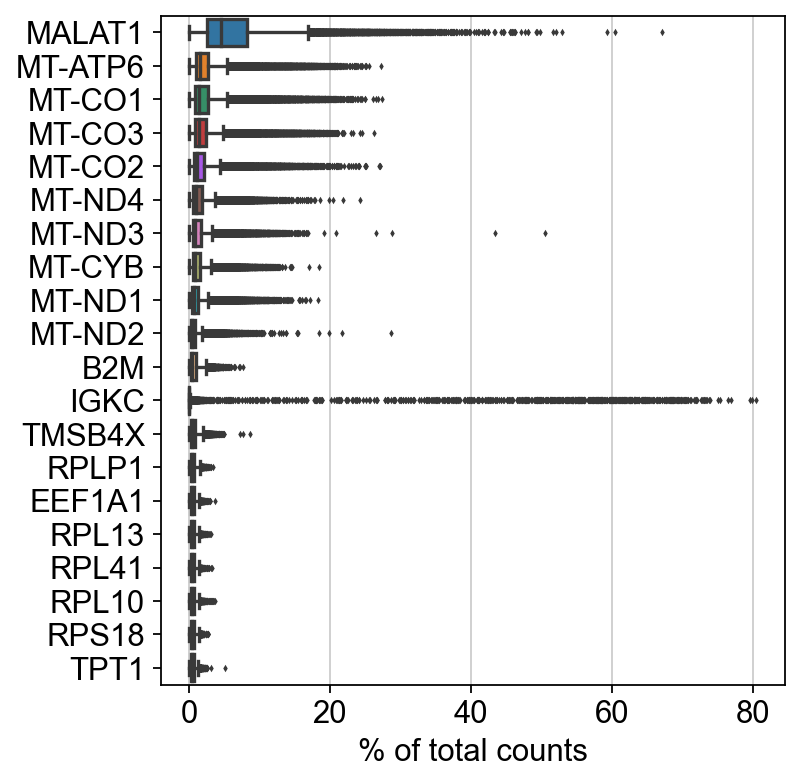

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
# qc——Filter out genes expressed in fewer than three cells or cell samples expressing fewer than 200 genes in a single cell
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1161 cells that have less than 200 genes expressed
filtered out 4765 genes that are detected in less than 3 cells


In [9]:
adata

AnnData object with n_obs × n_vars = 64659 × 23219
    obs: 'sample', 'group', 'n_genes'
    var: 'n_cells'

## Filtering cells that contain mitochondrial genes and over-expressed genes ##

- Transcripts of mitochondrial genes are larger than individual transcript molecules and are less likely to escape through the cell membrane. A high percentage of mitochondrial genes detected indicates poor cell quality.

- The over-expression of genes may be due to a single oil droplet encapsulating multiple cells, thus detecting a higher number of genes than would normally be detected, and therefore filtering these cells.

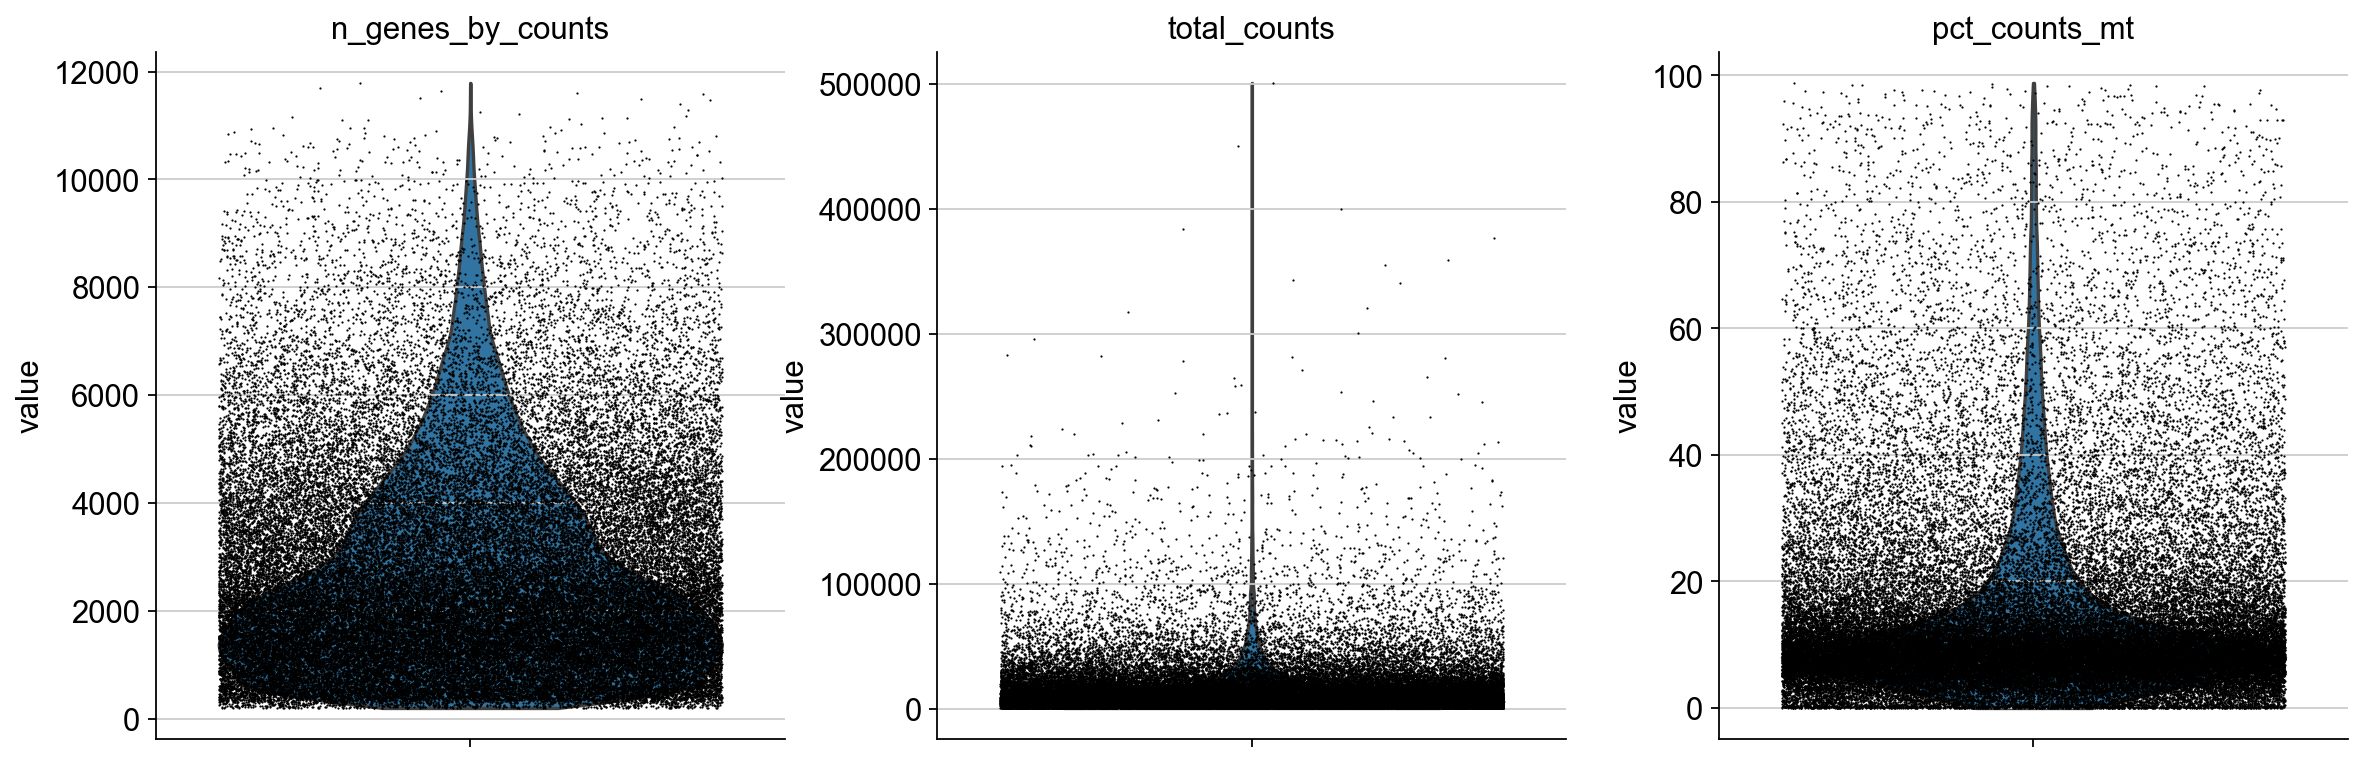

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

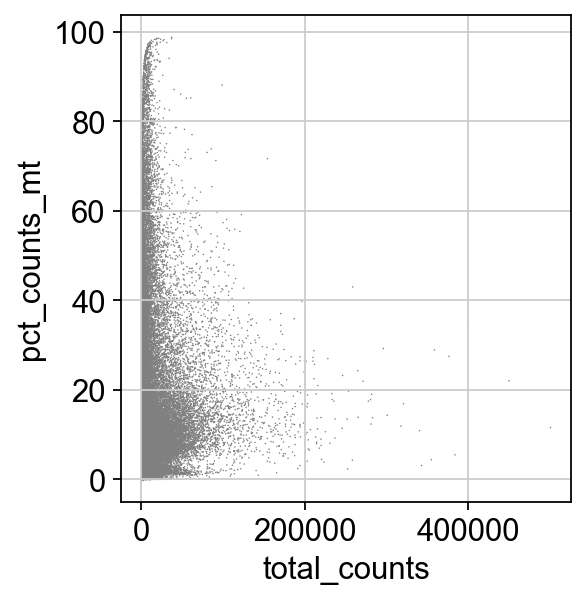

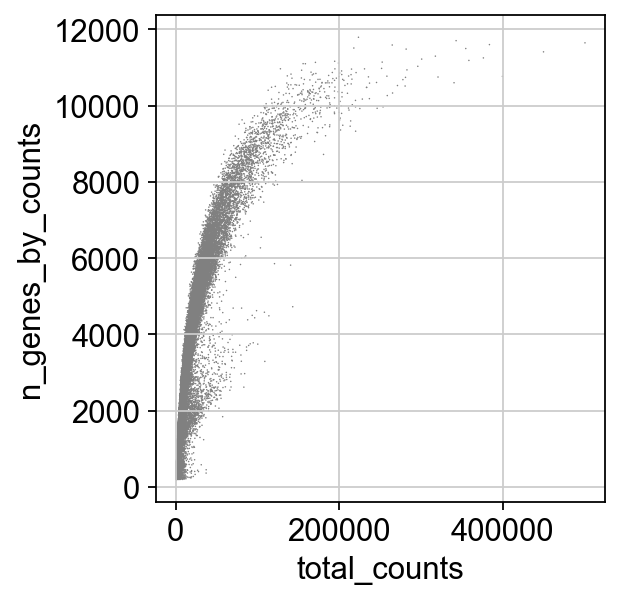

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
# 获取线粒体基因占比在20%以下的细胞样本
adata = adata[adata.obs.pct_counts_mt<20, :]
# 获取表达基因数在3500以下的细胞样本
adata = adata[adata.obs.n_genes_by_counts<10000, :]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 51215 × 23219
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Normalization

- Enables comparability between different cell samples

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


## Save data
    
- Set the .raw property of the AnnData object to normalized and logarithmic raw gene expression for later use in differential gene expression testing and visualization

In [16]:
adata.write("./GSE184880_HGSCO.h5ad")

## Read data

In [17]:
adata = sc.read_h5ad("./GSE184880_HGSCO.h5ad")

## Identify variable genes

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


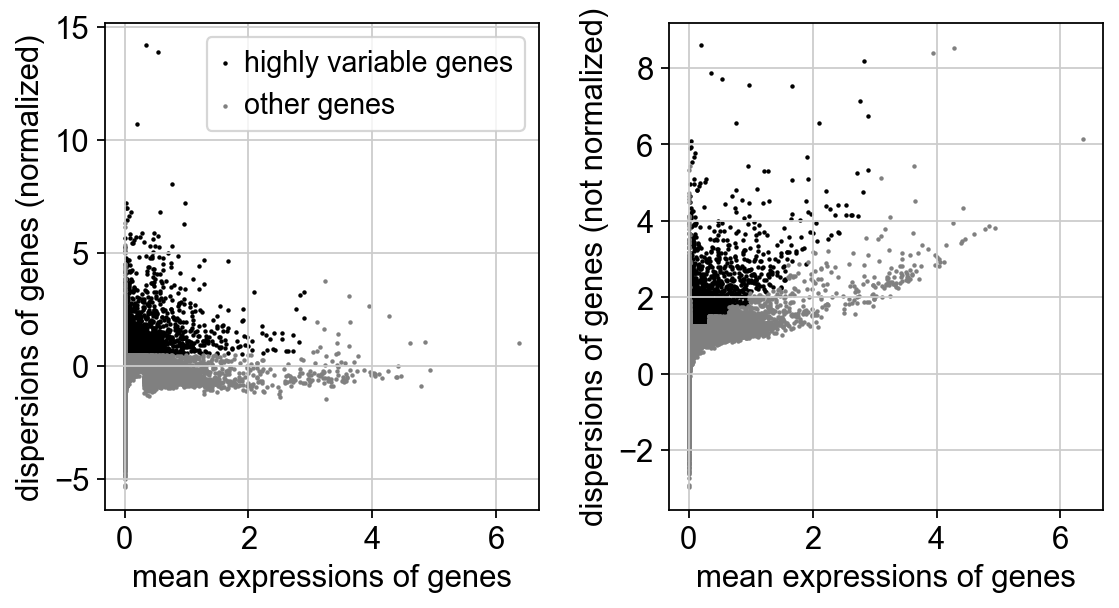

In [18]:
# calculate
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# plot 
sc.pl.highly_variable_genes(adata)

## acquire variable genes

In [19]:
adata = adata[:, adata.var.highly_variable]
# 回归每个细胞的总计数和表达的线粒体基因的百分比的影响.
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
# 将每个基因缩放到单位方差,阈值超过标准偏差10.
sc.pp.scale(adata, max_value=10)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:59)


In [20]:
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

## Run PCA 

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)


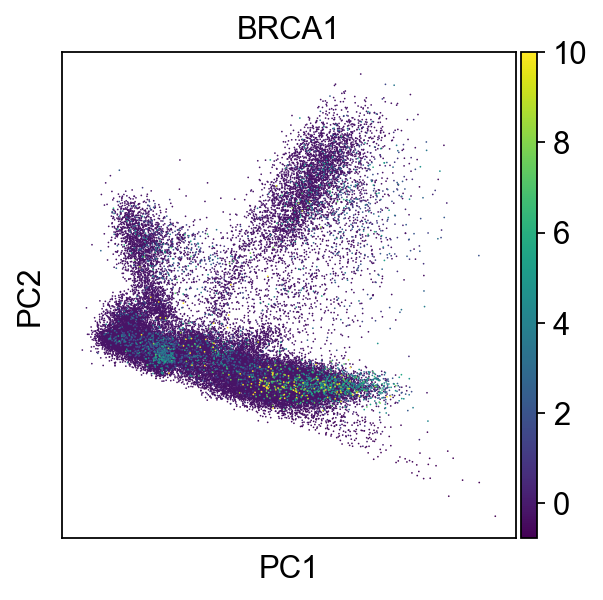

In [23]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata,color="BRCA1") #sc.pl.pca(adata，color="CST3")

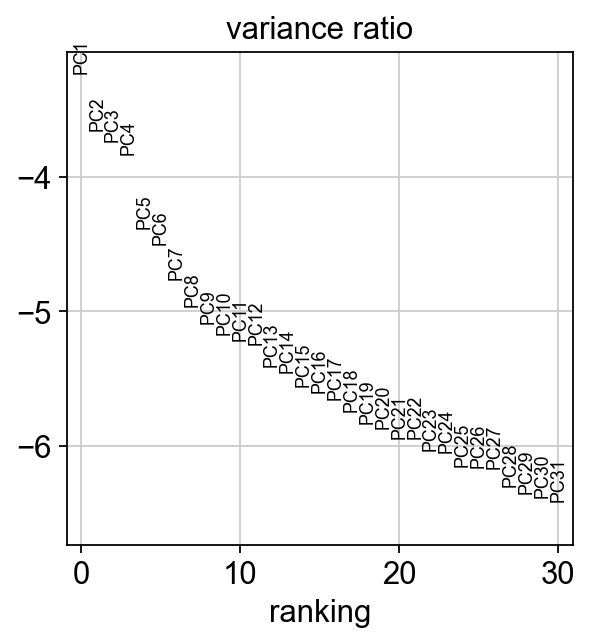

In [24]:
sc.pl.pca_variance_ratio(adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:08)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


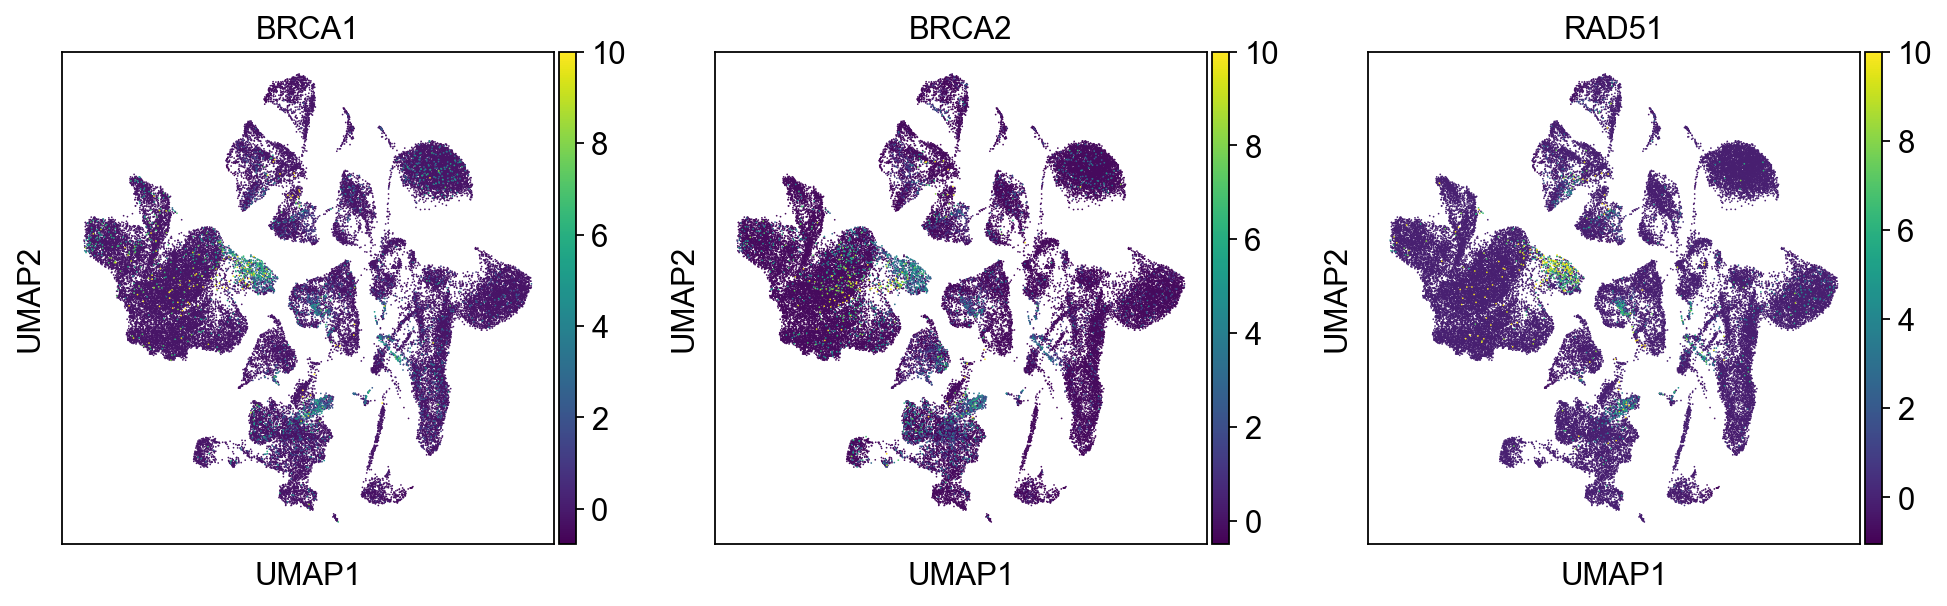

In [25]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['BRCA1', 'BRCA2', 'RAD51'])

## Leiden图聚类

running Leiden clustering
    finished: found 36 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:13)


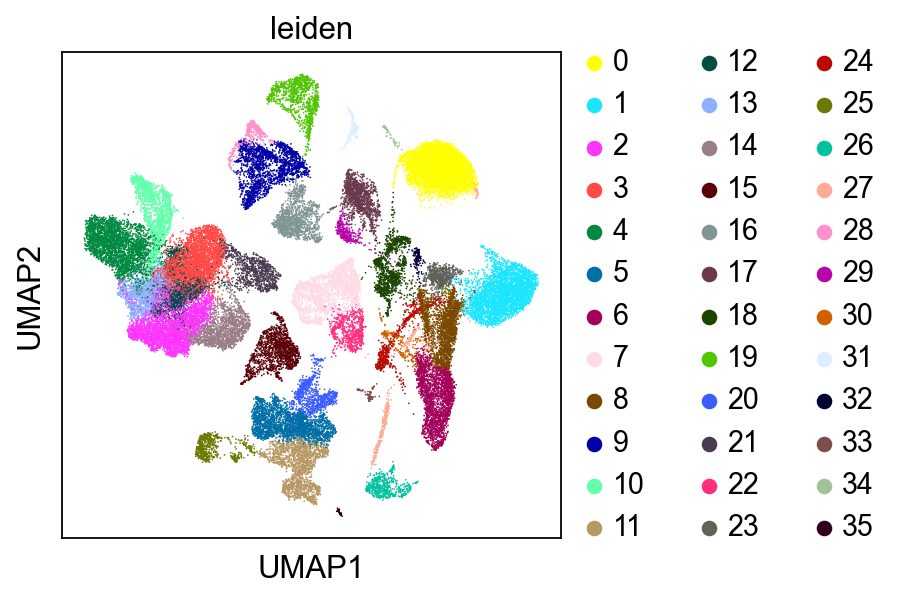

In [26]:
# 计算
sc.tl.leiden(adata)
# 绘制
sc.pl.umap(adata, color=['leiden'])

## umap

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


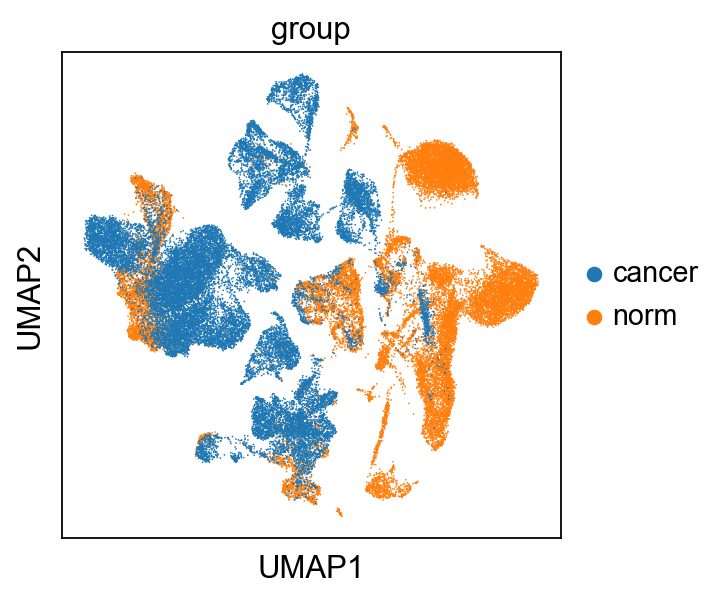

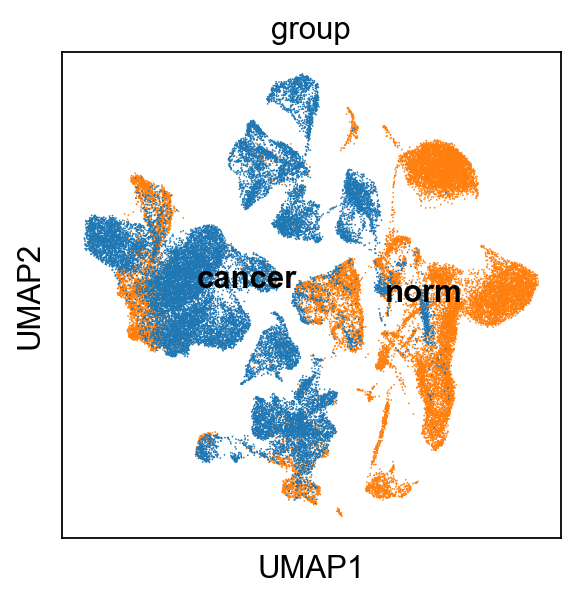

In [28]:
sc.pl.umap(adata, color=['group'])
sc.pl.umap(adata, color = ['group'], legend_loc = 'on data')

In [10]:
## ov scale and pca

In [31]:
ov.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

In [32]:
ov.pp.pca(adata,layer='scaled',n_pcs=50)
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

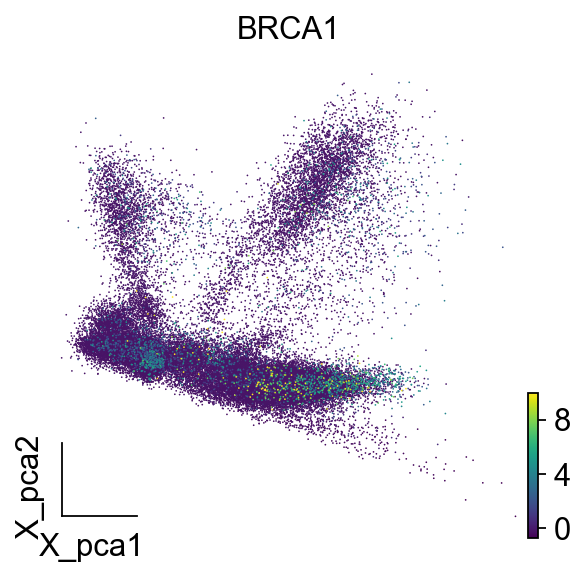

In [33]:
adata.obsm['X_pca']=adata.obsm['scaled|original|X_pca']
ov.utils.embedding(adata,
                  basis='X_pca',
                  color='BRCA1',#通过CST3的表达水平作色
                  frameon='small')

In [34]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50,
#选择每个细胞的最近15个邻居，50个主成分分析
               use_rep='scaled|original|X_pca')
#表示使用经过标准化和PCA分析后的数据进行邻居关系的计算

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


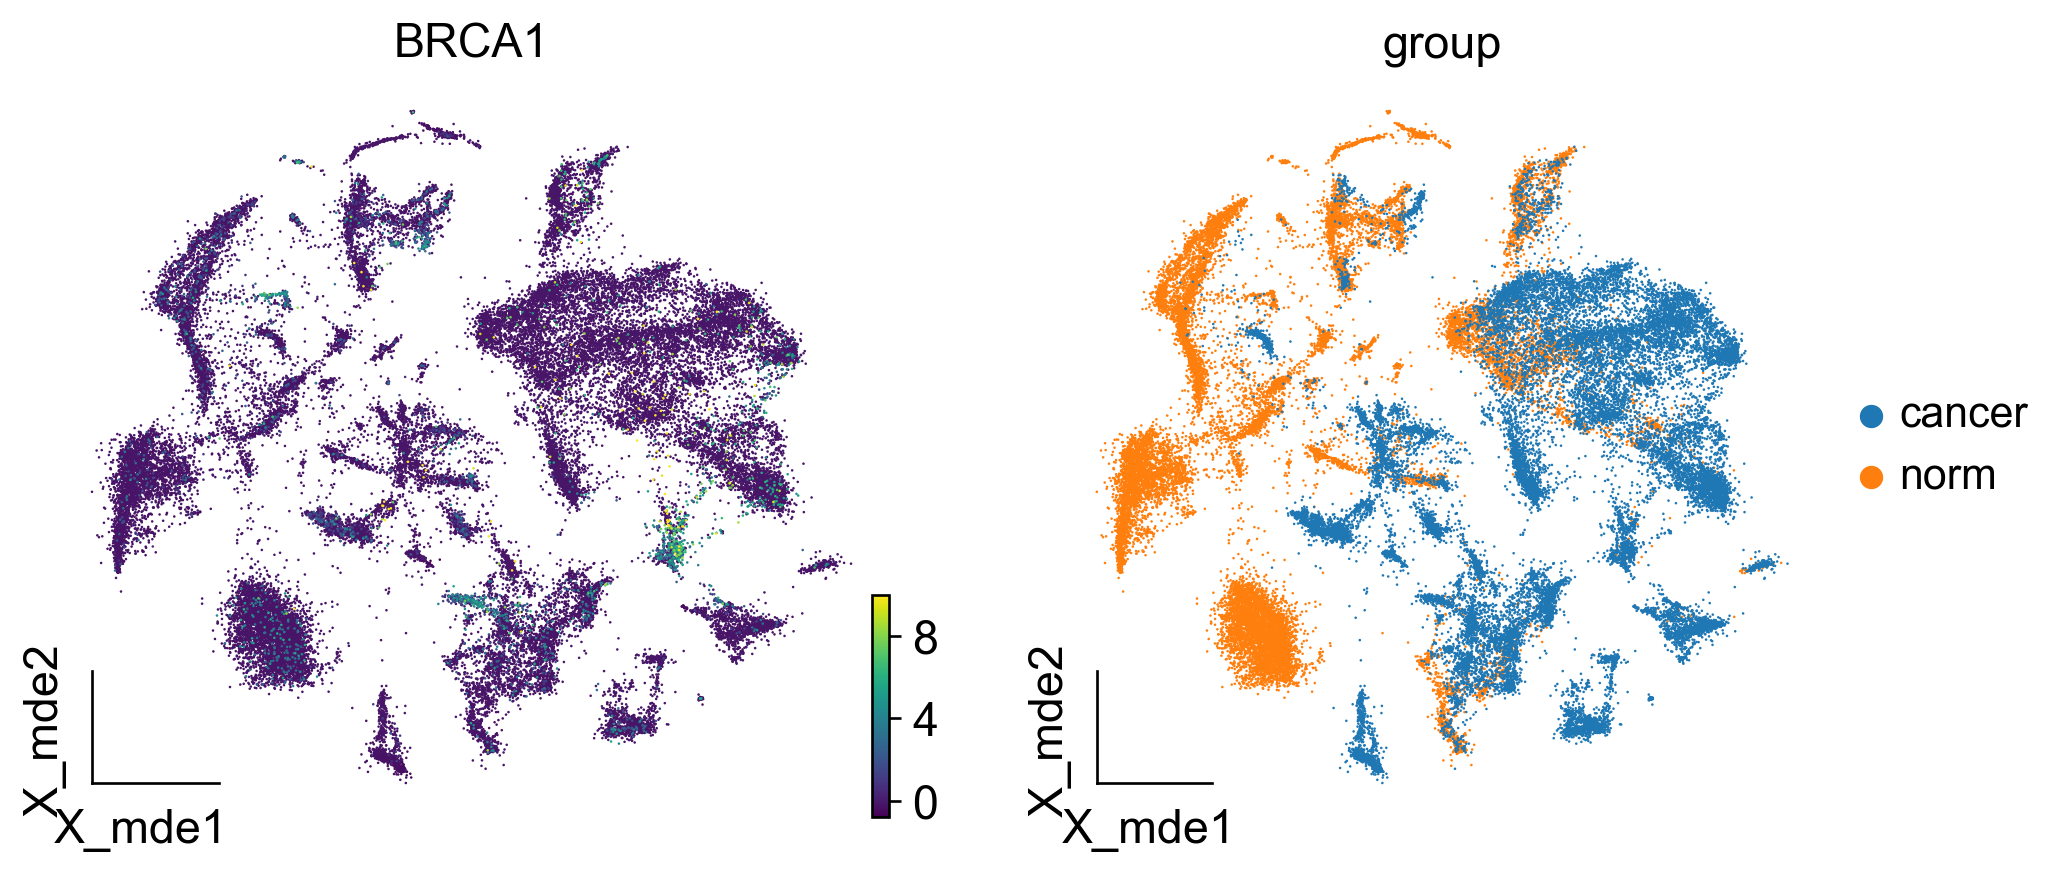

In [14]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])
adata
ov.utils.embedding(adata,
                basis='X_mde',
                color=['BRCA1','group'],
                frameon='small')

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:21)


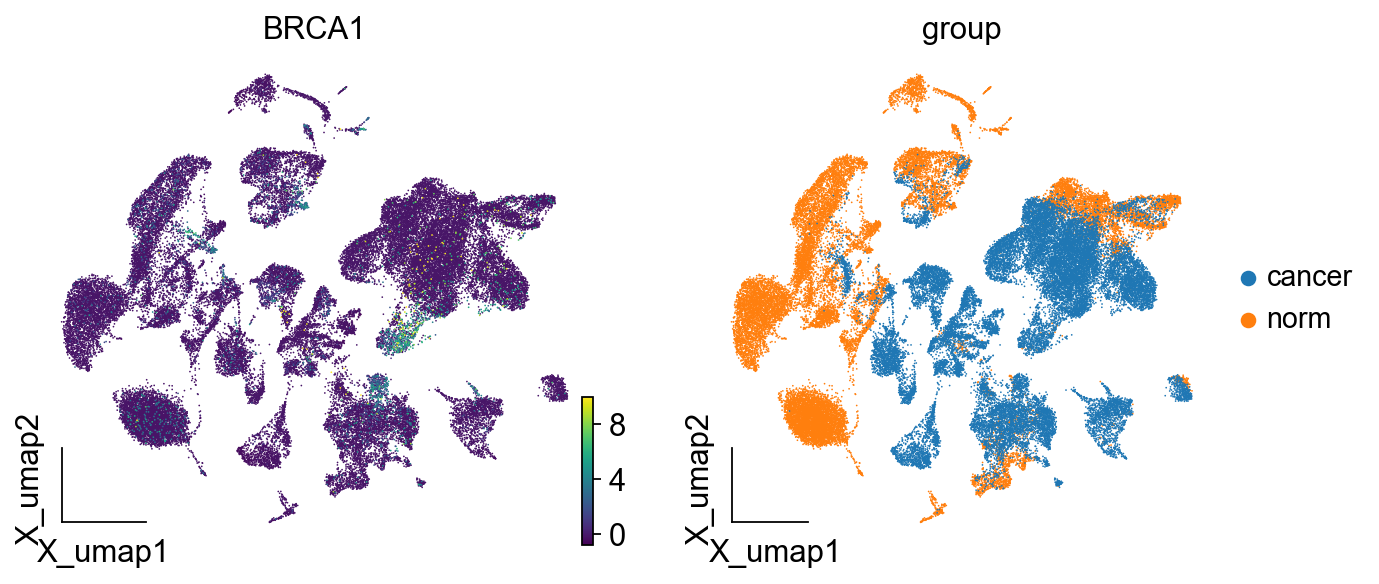

In [35]:
sc.tl.umap(adata)
ov.utils.embedding(adata,
                basis='X_umap',
                color=['BRCA1','group'],
                frameon='small')

In [36]:
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

In [ ]:
## 浏览全部已有leiden亚群

In [46]:
for i in adata.obs['leiden'].cat.categories:
  number = len(adata.obs[adata.obs['leiden']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category 0 is 4798
the number of category 1 is 3749
the number of category 2 is 3694
the number of category 3 is 3092
the number of category 4 is 2927
the number of category 5 is 2543
the number of category 6 is 2234
the number of category 7 is 2125
the number of category 8 is 2087
the number of category 9 is 2071
the number of category 10 is 1884
the number of category 11 is 1775
the number of category 12 is 1738
the number of category 13 is 1560
the number of category 14 is 1535
the number of category 15 is 1452
the number of category 16 is 1407
the number of category 17 is 1224
the number of category 18 is 1189
the number of category 19 is 1141
the number of category 20 is 944
the number of category 21 is 927
the number of category 22 is 726
the number of category 23 is 673
the number of category 24 is 622
the number of category 25 is 596
the number of category 26 is 540
the number of category 27 is 483
the number of category 28 is 352
the number of category 29 is 338


In [47]:
# 如果有些群细胞数目过少可以舍去
# adata = adata[adata.obs[adata.obs['leiden'].astype(int)<41].index] #40到42亚群所含细胞数过少,予以舍去
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

In [48]:
# 舍去之后更新结果

In [50]:
for i in adata.obs['leiden'].cat.categories:
  number = len(adata.obs[adata.obs['leiden']==i])
  print('the number of category {} is {}'.format(i,number))

the number of category 0 is 4798
the number of category 1 is 3749
the number of category 2 is 3694
the number of category 3 is 3092
the number of category 4 is 2927
the number of category 5 is 2543
the number of category 6 is 2234
the number of category 7 is 2125
the number of category 8 is 2087
the number of category 9 is 2071
the number of category 10 is 1884
the number of category 11 is 1775
the number of category 12 is 1738
the number of category 13 is 1560
the number of category 14 is 1535
the number of category 15 is 1452
the number of category 16 is 1407
the number of category 17 is 1224
the number of category 18 is 1189
the number of category 19 is 1141
the number of category 20 is 944
the number of category 21 is 927
the number of category 22 is 726
the number of category 23 is 673
the number of category 24 is 622
the number of category 25 is 596
the number of category 26 is 540
the number of category 27 is 483
the number of category 28 is 352
the number of category 29 is 338


<AxesSubplot: title={'center': 'leiden'}, xlabel='UMAP1', ylabel='UMAP2'>

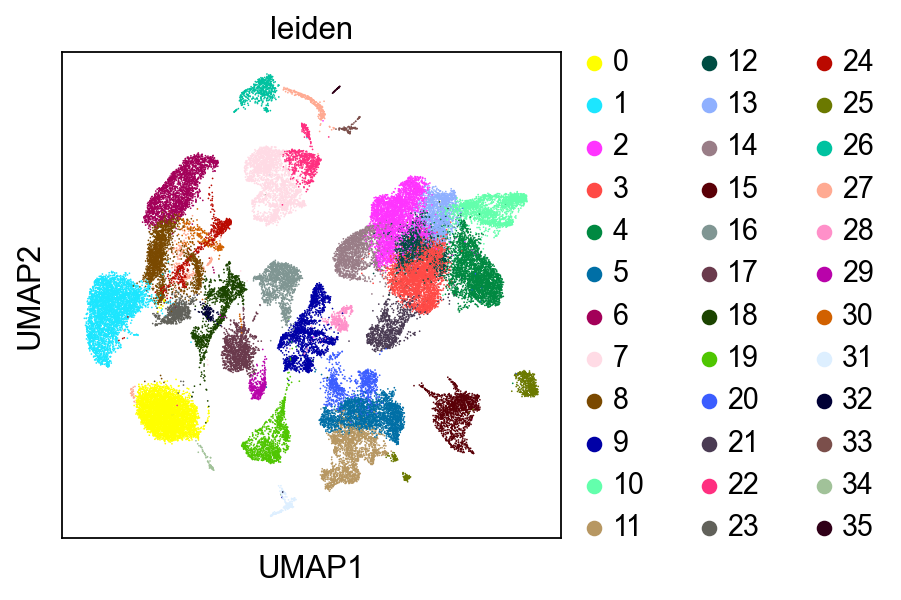

In [51]:
sc.pl.umap(adata, color=['leiden'], wspace=0.4, show=False)

In [52]:
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'scaled', 'lognorm'
    obsp: 'distances', 'connectivities'

## Cell type annotation

In [65]:
import decoupler as dc

In [67]:
# Query Omnipath and get PanglaoDB
markers = dc.get_resource('PanglaoDB')
markers

0.00B [00:00, ?B/s]

0.00B [00:00, ?B/s]

genesymbol canonical_marker          cell_type germ_layer human  \
0         CTRB1            False        Enterocytes   Endoderm  True   
1         CTRB1             True       Acinar cells   Endoderm  True   
2          KLK1             True  Endothelial cells   Mesoderm  True   
3          KLK1            False       Goblet cells   Endoderm  True   
4          KLK1            False   Epithelial cells   Mesoderm  True   
...         ...              ...                ...        ...   ...   
8456    SLC14A1             True   Urothelial cells   Mesoderm  True   
8457      UPK3A             True   Urothelial cells   Mesoderm  True   
8458      UPK1A             True   Urothelial cells   Mesoderm  True   
8459       UPK2             True   Urothelial cells   Mesoderm  True   
8460      UPK3B             True   Urothelial cells   Mesoderm  True   

     human_sensitivity human_specificity mouse mouse_sensitivity  \
0                  0.0        0.00439422  True        0.00331126   
1                  1.0       0.000628931  True          0.957143   
2                  0.0        0.00841969  True               0.0   
3             0.588235        0.00503937  True          0.903226   
4                  0.0        0.00823306  True          0.225806   
...                ...               ...   ...               ...   
8456               0.0         0.0181704  True               0.0   
8457               0.0               0.0  True               0.0   
8458               0.0               0.0  True               0.0   
8459               0.0               0.0  True               0.0   
8460               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
0            0.0204803        9606         GI tract           0.017  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
3            0.0124084        9606         GI tract           0.013  
4            0.0137585        9606       Epithelium           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[8461 rows x 13 columns]

In [68]:
# Filter by canonical_marker and human
markers = markers[(markers['human']=='True')&(markers['canonical_marker']=='True')]

# Remove duplicated entries
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers

genesymbol canonical_marker                     cell_type germ_layer  \
1         CTRB1             True                  Acinar cells   Endoderm   
2          KLK1             True             Endothelial cells   Mesoderm   
5          KLK1             True               Principal cells   Mesoderm   
6          KLK1             True                  Acinar cells   Endoderm   
7          KLK1             True  Plasmacytoid dendritic cells   Mesoderm   
...         ...              ...                           ...        ...   
8456    SLC14A1             True              Urothelial cells   Mesoderm   
8457      UPK3A             True              Urothelial cells   Mesoderm   
8458      UPK1A             True              Urothelial cells   Mesoderm   
8459       UPK2             True              Urothelial cells   Mesoderm   
8460      UPK3B             True              Urothelial cells   Mesoderm   

     human human_sensitivity human_specificity mouse mouse_sensitivity  \
1     True               1.0       0.000628931  True          0.957143   
2     True               0.0        0.00841969  True               0.0   
5     True               0.0        0.00814536  True          0.285714   
6     True          0.833333        0.00503145  True          0.314286   
7     True               0.0        0.00820189  True               1.0   
...    ...               ...               ...   ...               ...   
8456  True               0.0         0.0181704  True               0.0   
8457  True               0.0               0.0  True               0.0   
8458  True               0.0               0.0  True               0.0   
8459  True               0.0               0.0  True               0.0   
8460  True               0.0               0.0  True               0.0   

     mouse_specificity ncbi_tax_id            organ ubiquitiousness  
1            0.0159201        9606         Pancreas           0.017  
2            0.0149153        9606      Vasculature           0.013  
5            0.0140583        9606           Kidney           0.013  
6            0.0128263        9606         Pancreas           0.013  
7            0.0129136        9606    Immune system           0.013  
...                ...         ...              ...             ...  
8456               0.0        9606  Urinary bladder           0.008  
8457               0.0        9606  Urinary bladder             0.0  
8458               0.0        9606  Urinary bladder             0.0  
8459               0.0        9606  Urinary bladder             0.0  
8460               0.0        9606  Urinary bladder             0.0  

[5180 rows x 13 columns]

In [71]:
dc.run_ora(
    mat=adata,
    net=markers,
    source='cell_type',
    target='genesymbol',
    min_n=3,
    verbose=True,use_raw=False
)

Running ora on mat with 51215 samples and 3533 targets for 117 sources.


100%|██████████| 51215/51215 [00:25<00:00, 2014.09it/s]


In [72]:
adata.obsm['ora_estimate']

source              Acinar cells  Adipocytes  Airway goblet cells  \
AAACCCAAGGACAGCT-1      1.918511    3.214226            -0.000000   
AAACCCAAGGTATCTC-1      0.808354    1.237830            -0.000000   
AAACCCACAAGTGCAG-1     -0.000000    1.237830            -0.000000   
AAACCCACACCCTCTA-1     -0.000000    1.237830            -0.000000   
AAACCCACACTCCGGA-1      0.808354    0.489460            -0.000000   
...                          ...         ...                  ...   
TTTGGTTAGTTGGCTT-1      0.808354    2.160112            -0.000000   
TTTGGTTGTTCCTACC-1      1.918511    1.237830            -0.000000   
TTTGGTTGTTTCGCTC-1      1.918511    3.214226            -0.000000   
TTTGGTTTCCACAAGT-1     -0.000000    0.489460             1.284454   
TTTGTTGCATCCTAAG-1     -0.000000    1.237830            -0.000000   

source              Alpha cells  Alveolar macrophages  Astrocytes   B cells  \
AAACCCAAGGACAGCT-1    -0.000000                  -0.0   -0.000000  0.643239   
AAACCCAAGGTATCTC-1    -0.000000                  -0.0   -0.000000 -0.000000   
AAACCCACAAGTGCAG-1     1.219408                  -0.0    0.787943 -0.000000   
AAACCCACACCCTCTA-1    -0.000000                  -0.0    0.787943 -0.000000   
AAACCCACACTCCGGA-1    -0.000000                  -0.0    3.157779  0.643239   
...                         ...                   ...         ...       ...   
TTTGGTTAGTTGGCTT-1    -0.000000                  -0.0   -0.000000  1.568005   
TTTGGTTGTTCCTACC-1     1.219408                  -0.0    1.875264  1.568005   
TTTGGTTGTTTCGCTC-1     1.219408                  -0.0   -0.000000  0.643239   
TTTGGTTTCCACAAGT-1    -0.000000                  -0.0    0.787943 -0.000000   
TTTGTTGCATCCTAAG-1    -0.000000                  -0.0    0.787943  2.677289   

source              B cells memory  B cells naive  Basal cells  ...  \
AAACCCAAGGACAGCT-1       -0.000000      -0.000000    -0.000000  ...   
AAACCCAAGGTATCTC-1       -0.000000      -0.000000    -0.000000  ...   
AAACCCACAAGTGCAG-1       -0.000000      -0.000000    -0.000000  ...   
AAACCCACACCCTCTA-1       -0.000000      -0.000000    -0.000000  ...   
AAACCCACACTCCGGA-1       -0.000000      -0.000000     1.284454  ...   
...                            ...            ...          ...  ...   
TTTGGTTAGTTGGCTT-1        2.276181       0.572554    -0.000000  ...   
TTTGGTTGTTCCTACC-1        0.523640       0.572554     2.942615  ...   
TTTGGTTGTTTCGCTC-1       -0.000000      -0.000000     1.284454  ...   
TTTGGTTTCCACAAGT-1        0.523640      -0.000000    -0.000000  ...   
TTTGTTGCATCCTAAG-1        1.311750       1.416940    -0.000000  ...   

source              Sertoli cells  Smooth muscle cells   T cells  \
AAACCCAAGGACAGCT-1       0.750273             1.372943  0.542294   
AAACCCAAGGTATCTC-1       0.750273             2.372109  0.542294   
AAACCCACAAGTGCAG-1       0.750273             2.372109 -0.000000   
AAACCCACACCCTCTA-1       0.750273             1.372943 -0.000000   
AAACCCACACTCCGGA-1       4.416880             1.372943 -0.000000   
...                           ...                  ...       ...   
TTTGGTTAGTTGGCTT-1       1.795422            -0.000000  8.902396   
TTTGGTTGTTCCTACC-1       1.795422            -0.000000 -0.000000   
TTTGGTTGTTTCGCTC-1       1.795422            -0.000000 -0.000000   
TTTGGTTTCCACAAGT-1      -0.000000            -0.000000  6.016265   
TTTGTTGCATCCTAAG-1      -0.000000            -0.000000  7.422468   

source              T helper cells  T regulatory cells  Tanycytes  \
AAACCCAAGGACAGCT-1       -0.000000           -0.000000   1.070194   
AAACCCAAGGTATCTC-1       -0.000000           -0.000000   1.070194   
AAACCCACAAGTGCAG-1       -0.000000           -0.000000   2.475618   
AAACCCACACCCTCTA-1       -0.000000           -0.000000   2.475618   
AAACCCACACTCCGGA-1       -0.000000            1.070194   4.107200   
...                            ...                 ...        ...   
TTTGGTTAGTTGGCTT-1        2.179886           -0.000000  -0.000000   


In [83]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed for pvals=0
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 51215 × 117
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'group_colors', 'scaled|original|pca_var_ratios', 'scaled|original|cum_sum_eigenvalues', 'dendrogram_leiden', 'cell_type_colors'
    obsm: 'X_pca', 'X_umap', 'scaled|original|X_pca', 'ora_estimate', 'ora_pvals'

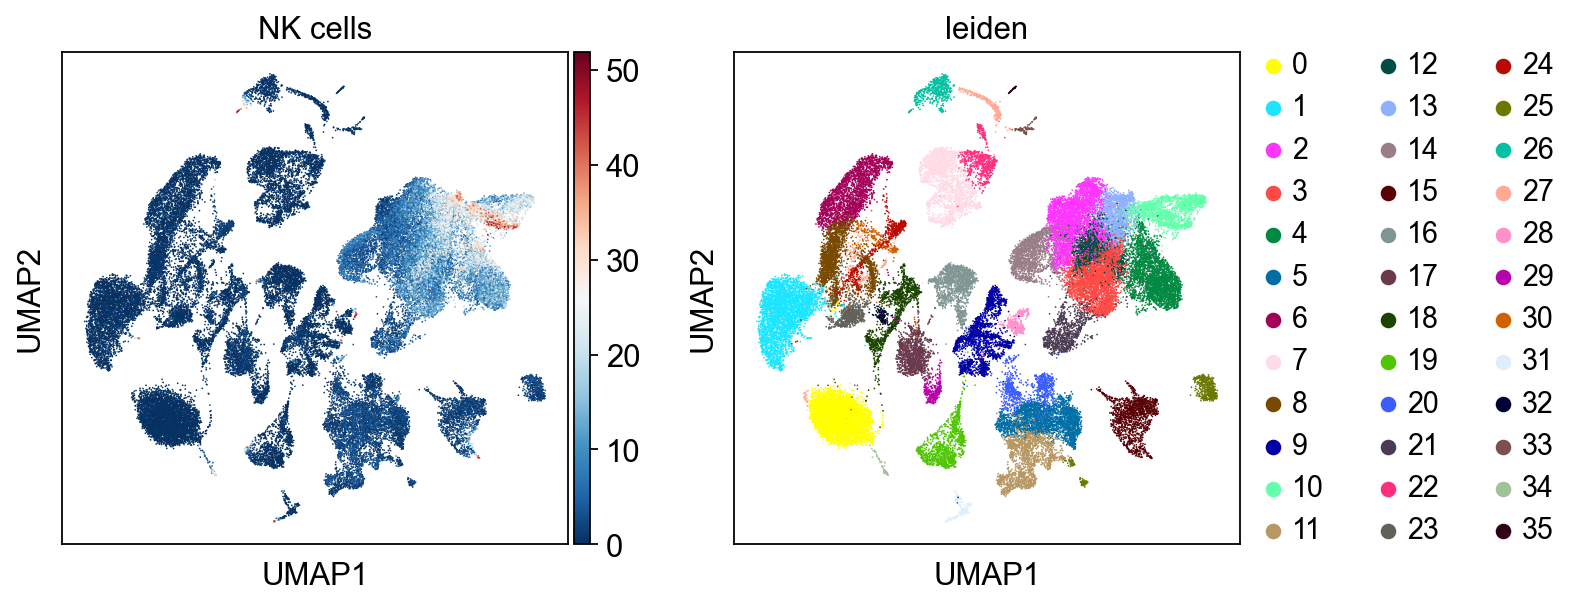

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


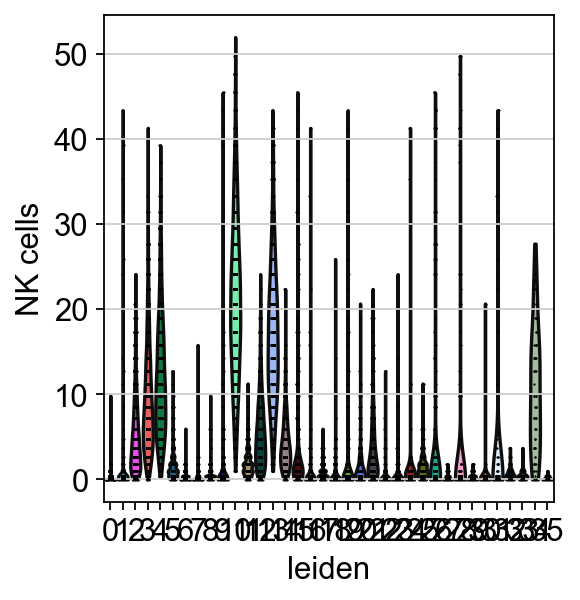

In [84]:
sc.pl.umap(acts, color=['NK cells', 'leiden'], cmap='RdBu_r')
sc.pl.violin(acts, keys=['NK cells'], groupby='leiden')

In [85]:
df = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')
df

group reference                      names  statistic  meanchange  \
0        0      rest            Meningeal cells  47.997816    1.200003   
1        0      rest               Leydig cells  47.263103    2.228637   
2        0      rest                  Tanycytes  39.769431    0.848573   
3        0      rest              Sertoli cells  29.161866    0.866756   
4        0      rest                 Beta cells  26.998368    0.538001   
...    ...       ...                        ...        ...         ...   
4207     9      rest             T helper cells -23.407537   -0.744910   
4208     9      rest                  Platelets -23.822154   -1.342119   
4209     9      rest  Pancreatic stellate cells -23.988940   -2.479200   
4210     9      rest     Natural killer T cells -25.361155   -0.998039   
4211     9      rest                Fibroblasts -26.067063   -5.381175   

              pvals      pvals_adj  
0      0.000000e+00   0.000000e+00  
1      0.000000e+00   0.000000e+00  
2      0.000000e+00   0.000000e+00  
3     3.483202e-179  1.567441e-178  
4     3.333535e-154  1.218824e-153  
...             ...            ...  
4207  4.112090e-109  1.718266e-108  
4208  7.168241e-116  3.494517e-115  
4209  1.230181e-112  5.330783e-112  
4210  7.385038e-126  3.927498e-125  
4211  4.285332e-130  2.387542e-129  

[4212 rows x 7 columns]

In [86]:
# extract top 3 cell types for each cluster
n_ctypes = 3
ctypes_dict = df.groupby('group').head(n_ctypes).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
ctypes_dict

{'0': ['Meningeal cells', 'Leydig cells', 'Tanycytes'],
 '1': ['Hepatic stellate cells', 'Fibroblasts', 'Adipocytes'],
 '10': ['NK cells', 'Gamma delta T cells', 'Natural killer T cells'],
 '11': ['Dendritic cells', 'Macrophages', 'Monocytes'],
 '12': ['Plasma cells', 'Thymocytes', 'T cells'],
 '13': ['T cells', 'NK cells', 'Thymocytes'],
 '14': ['T regulatory cells', 'T helper cells', 'Thymocytes'],
 '15': ['Plasma cells', 'B cells', 'Plasmacytoid dendritic cells'],
 '16': ['Luminal epithelial cells', 'Cholangiocytes', 'Epiblast cells'],
 '17': ['Pancreatic stellate cells', 'Fibroblasts', 'Osteoblasts'],
 '18': ['Pericytes', 'Smooth muscle cells', 'Glomus cells'],
 '19': ['Cholangiocytes', 'Ductal cells', 'Alpha cells'],
 '2': ['T cells', 'Nuocytes', 'Thymocytes'],
 '20': ['Kupffer cells', 'Macrophages', 'Microglia'],
 '21': ['Gamma delta T cells', 'Germ cells', 'Neuroblasts'],
 '22': ['Taste receptor cells', 'Embryonic stem cells', 'Principal cells'],
 '23': ['Hepatic stellate cells'

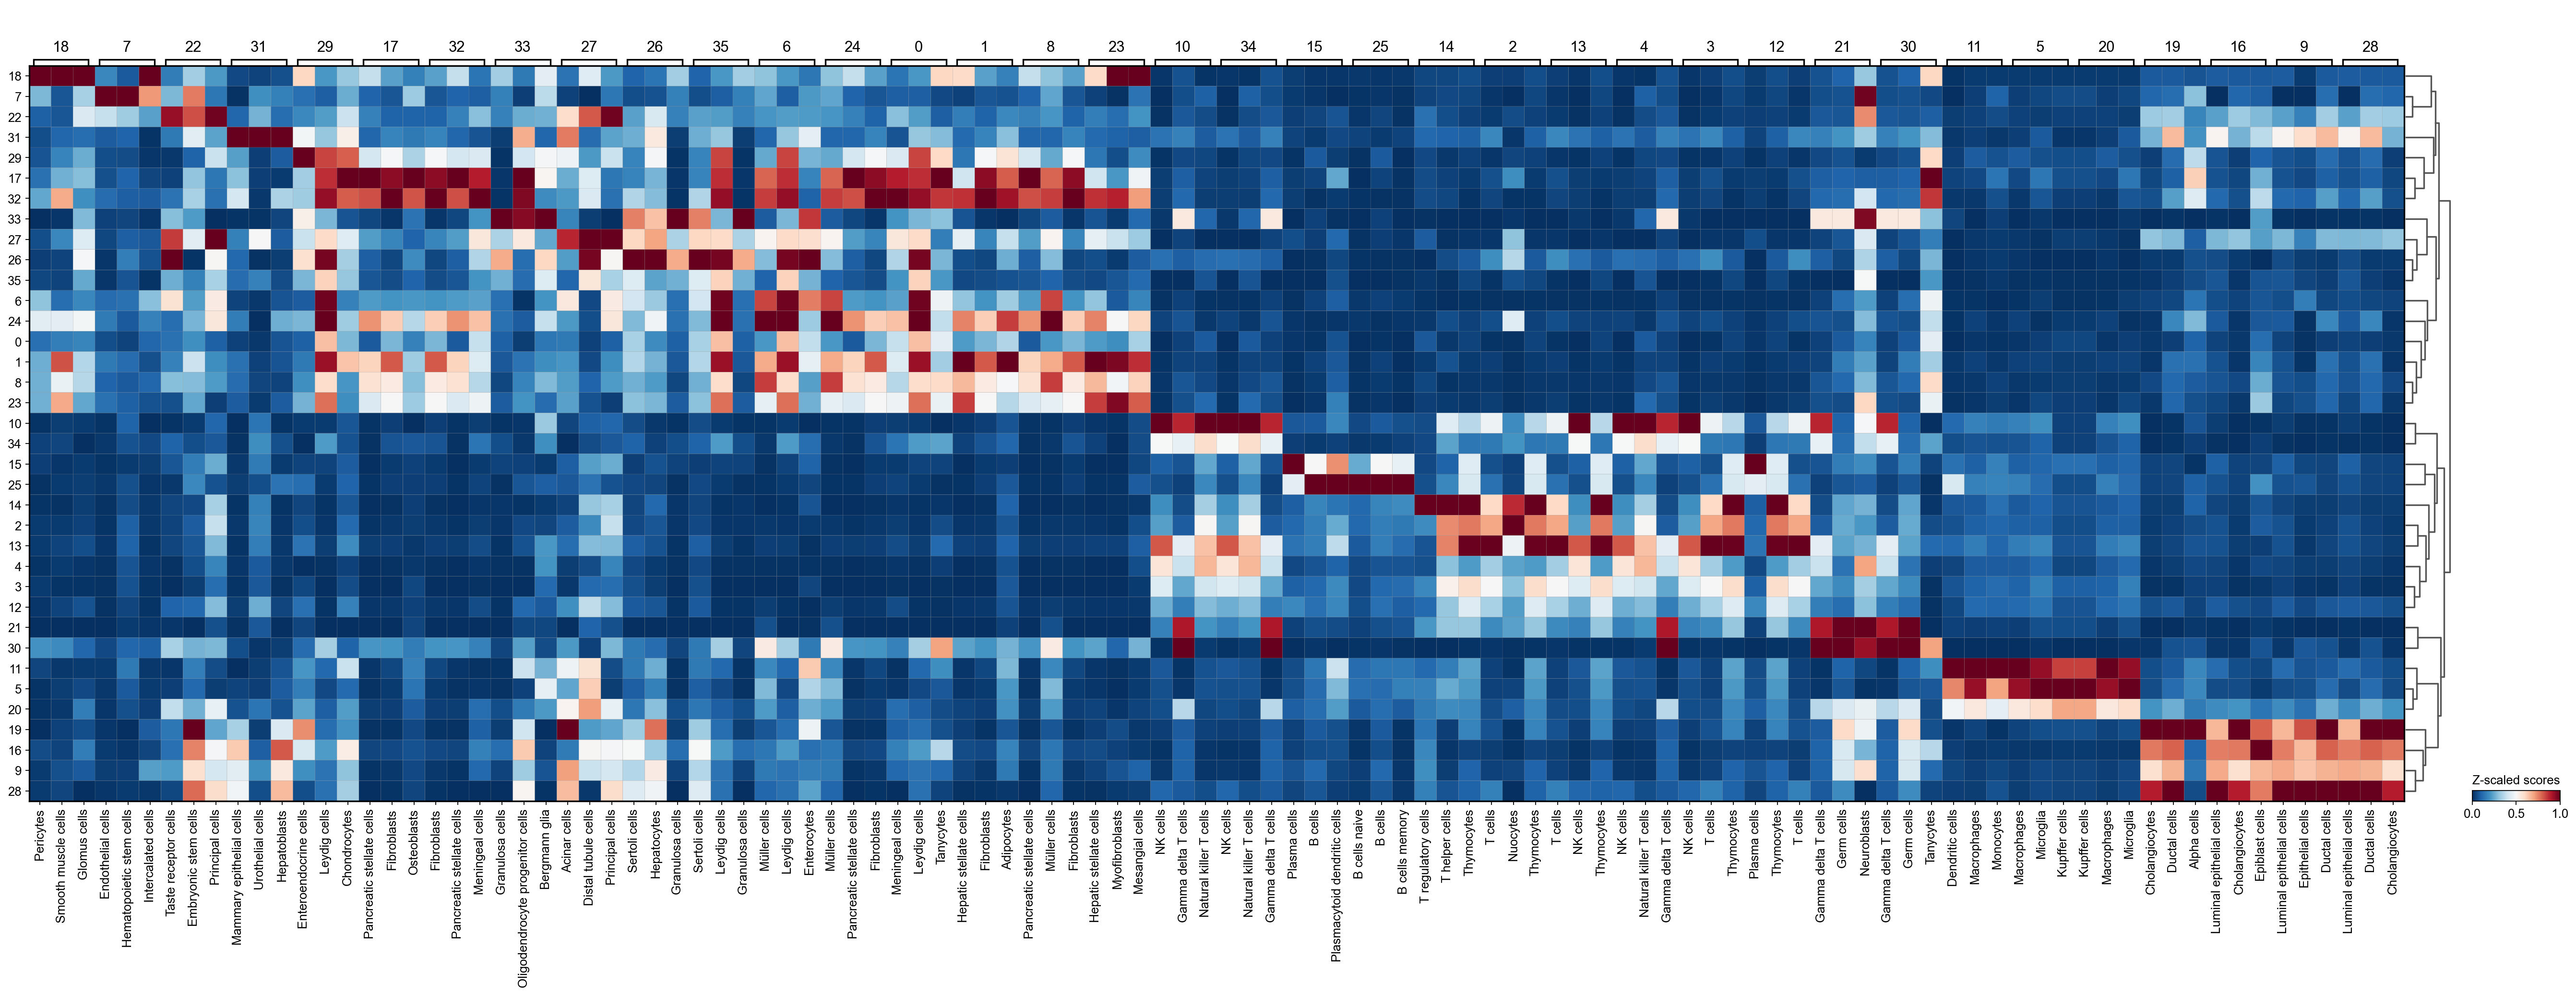

In [87]:
sc.pl.matrixplot(acts, ctypes_dict, 'leiden', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings 

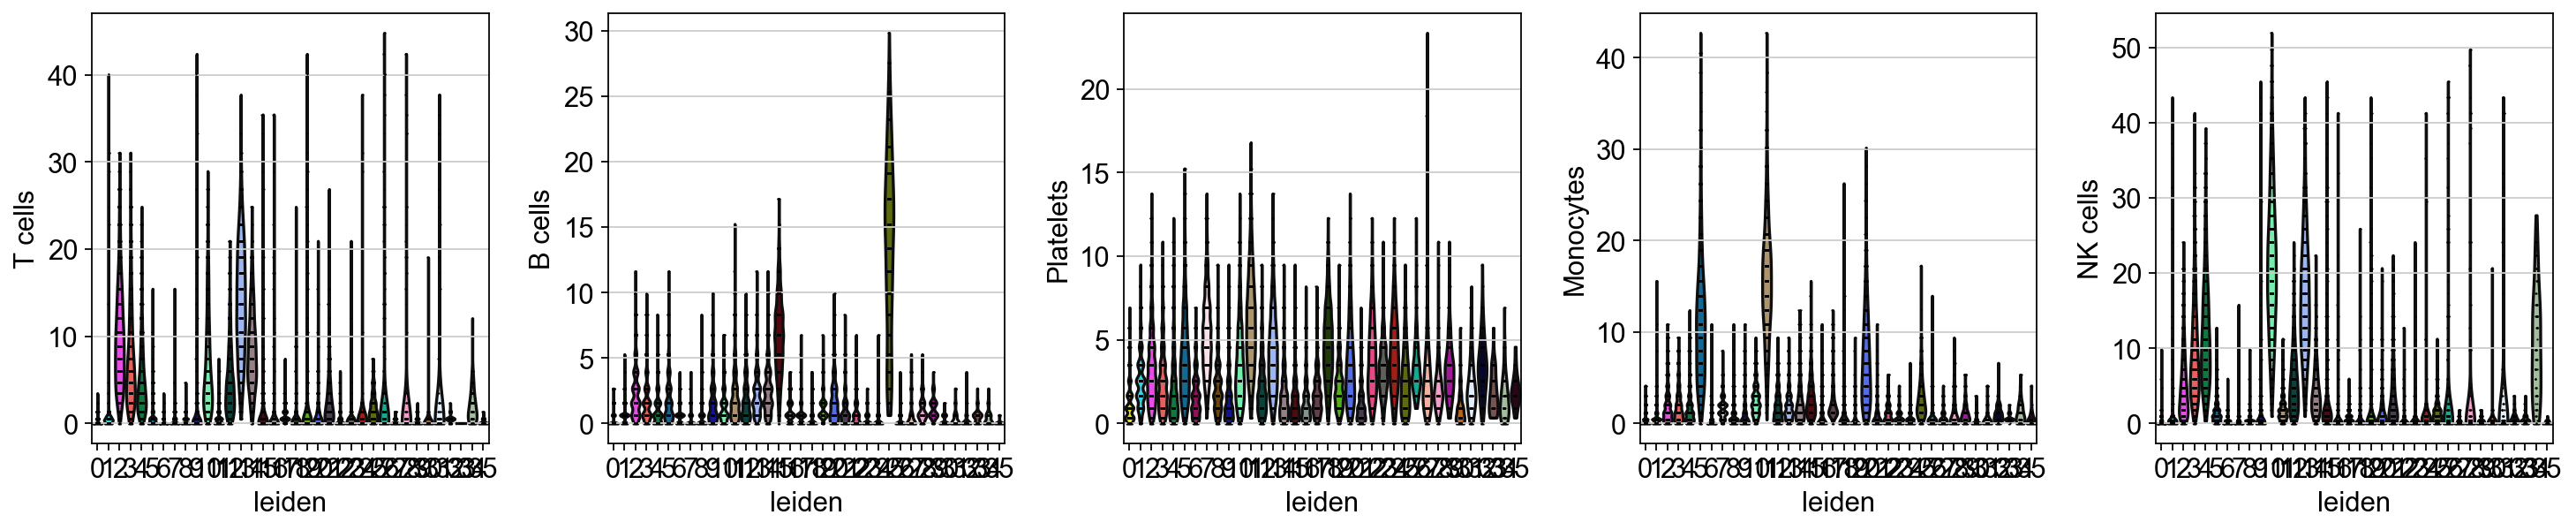

In [112]:
sc.pl.violin(acts, keys=['T cells', 'B cells', 'Platelets', 'Monocytes', 'NK cells'], groupby='leiden')

In [101]:
annotation_dict = df.groupby('group').head(1).set_index('group')['names'].to_dict()
annotation_dict


{'0': 'Meningeal cells',
 '1': 'Hepatic stellate cells',
 '10': 'NK cells',
 '11': 'Dendritic cells',
 '12': 'Plasma cells',
 '13': 'T cells',
 '14': 'T regulatory cells',
 '15': 'Plasma cells',
 '16': 'Luminal epithelial cells',
 '17': 'Pancreatic stellate cells',
 '18': 'Pericytes',
 '19': 'Cholangiocytes',
 '2': 'T cells',
 '20': 'Kupffer cells',
 '21': 'Gamma delta T cells',
 '22': 'Taste receptor cells',
 '23': 'Hepatic stellate cells',
 '24': 'Müller cells',
 '25': 'B cells naive',
 '26': 'Sertoli cells',
 '27': 'Acinar cells',
 '28': 'Luminal epithelial cells',
 '29': 'Enteroendocrine cells',
 '3': 'NK cells',
 '30': 'Gamma delta T cells',
 '31': 'Mammary epithelial cells',
 '32': 'Fibroblasts',
 '33': 'Granulosa cells',
 '34': 'NK cells',
 '35': 'Sertoli cells',
 '4': 'NK cells',
 '5': 'Macrophages',
 '6': 'Müller cells',
 '7': 'Endothelial cells',
 '8': 'Pancreatic stellate cells',
 '9': 'Luminal epithelial cells'}

... storing 'cell_type' as categorical


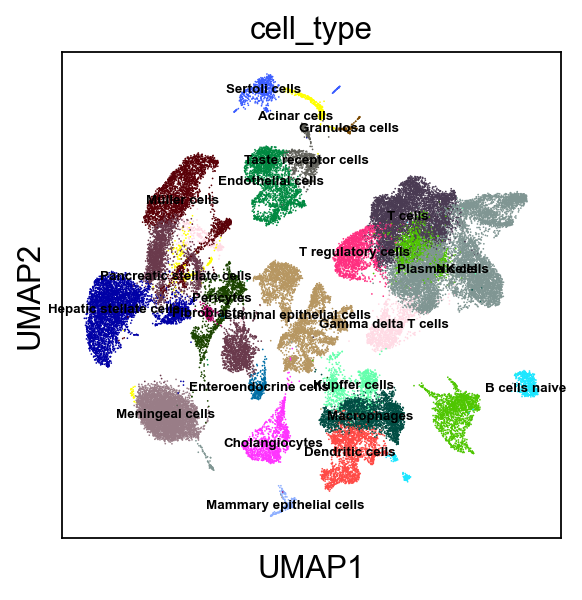

In [110]:
# Add cell type column based on annotation
adata.obs['cell_type'] = [annotation_dict[clust] for clust in adata.obs['leiden']]

# Visualize
sc.pl.umap(adata, color='cell_type', legend_loc='on data', legend_fontsize=6,save='.pdf')

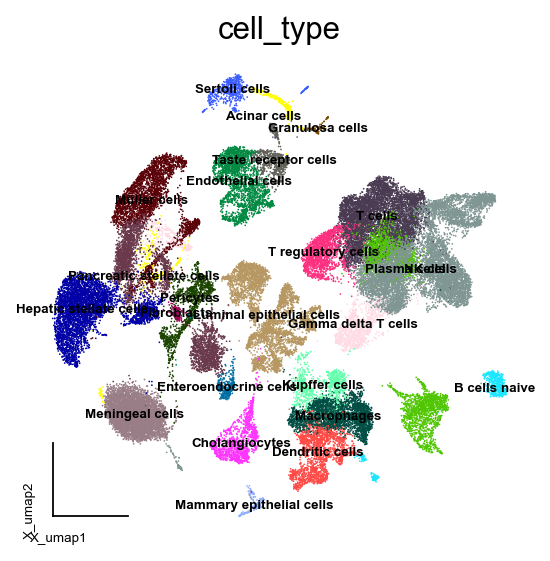

In [111]:
ov.utils.embedding(adata,
                basis='X_umap',
                color='cell_type',
                frameon='small',
                legend_loc='on data',
                legend_fontsize=6,
                save='.pdf')


In [105]:
## save the result

adata.write("./GSE184880_HGSCO_annoed.h5ad")